# Pandemia de Covid-19 no Ceará: Podemos Começar a ter Esperança por Dias Melhores? As Previsões de Séries Temporais com Prophet nos ajudarão na resposta!

No momento que atingimos a triste marca de meio milhão de mortos pela Covid-19 só no Brasil, cabe a nós uma reflexão sobre esse cenário que estamos vivenciando. Cabe a nós buscar alguma "luz no fim do túnel", luz essa em formato de vacina e também de impeachment.

Nesse contexto, busco trazer uma breve análise sobre as curvas de novos casos e novos óbitos por Covid-19 no Ceará. Além disso, são trazidas previsões que podem nos ajudar a entender para onde esses números estão tendendo. Números não, vidas!


**Ciência de Dados na Pandemia de Covid-19 no Ceará?!**

Em 2020 e em 2021 a [Secretaria de Saúde do Estado do Ceará](https://www.saude.ce.gov.br/) realizou diversas ações convidando a própria comunidade de ciência de dados a ajudar nos esforços contra a doença, fornecendo análises e previsões acerca dos dados abertos fornecidos pelo próprio SUS.

<p align = "center">
    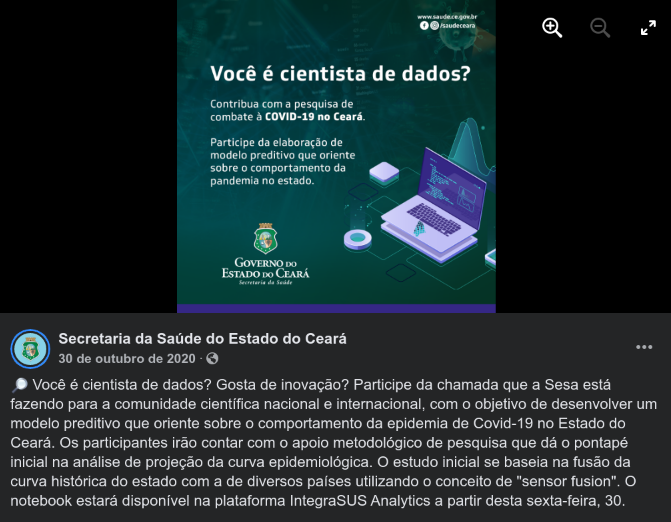
</p>


**Acima:** _Chamado da Secretária de Saúde do Ceará para o concurso de Ciência de Dados para prever os casos de Covid-19_

Esse concurso é bem explicado no link a seguir. Vale a pena a leitura, pois também fornece um enorme contexto para o uso de ciência de dados na saúde.

- [Sesa busca propostas de ferramentas para prever curva da Covid-19](https://diariodonordeste.verdesmares.com.br/metro/sesa-busca-propostas-de-ferramentas-para-prever-curva-da-covid-19-1.3009707)

Com isso também foi lançado o [IntegraSUS Analytics](https://integrasusanalytics.saude.ce.gov.br/pt/home), plataforma do Governo do Ceará de Ciência de Dados relacionada à Covid-19.

- [Secretaria da Saúde do Ceará lança plataforma de dados IntegraSUS Analytics](http://www.issec.ce.gov.br/index.php/assessoria-de-comunicacao/listanoticias/932-secretaria-da-saude-do-ceara-lanca-plataforma-de-dados-integrasus-analytics)

# Dados

Nesse projeto foram obtidos os dados de casos e óbitos por Covid-19 no Ceará no site do [Brasil.io](https://brasil.io/home/), um excelente repositório de dados públicos do nosso país.

Foi selecionado o dataset principal sobre a doença, disponível em: [Covid-19 - Brasil.io](https://brasil.io/dataset/covid19/caso_full/)

O próprio site nos diz que:

> Essa tabela possui os casos confirmados e óbitos obtidos dos boletins das Secretarias Estaduais de Saúde (SES). Os dados foram enriquecidos, de forma que a partir do momento em que um município confirma um caso, ele sempre aparecerá nessa tabela (mesmo que para uma determinada data a SES não tenha liberado o boletim - nesse caso é repetido o dado do dia anterior). Caso queira ver a tabela original (sem repetição e com datas faltantes), visite [caso](https://brasil.io/dataset/covid19/caso/).

O dataset utilizado nesse notebook possui sua última atualização no dia **29/06/2021** e uma cópia desse dataset encontra-se no [repositório do projeto](https://github.com/diascarolina/projeto-series-temporais-covid/blob/main/data/caso_full.csv.gz).

<div class="alert alert-success">
    <strong><a href='https://github.com/diascarolina/projeto-series-temporais-covid/blob/main/notebooks/limpeza-dados.ipynb'>Notebook de Limpeza dos Dados Sobre a Covid-19</a></strong>
</div>


Também foi feita uma breve análise sobre a vacinação contra a doença. Os dados foram extraídos de:

- [OpenDataSUS: Registros de Vacinação COVID-19](https://opendatasus.saude.gov.br/dataset/covid-19-vacinacao/resource/ef3bd0b8-b605-474b-9ae5-c97390c197a8)

Como os dados são sobre cada aplicação individual da vacina, os arquivos são muito grandes. Por isso, adaptei os datasets para termos os dados da contagem de quantas doses de vacina foram aplicadas por dia, obtendo assim um arquivo bem menor que pode ser encontrado [aqui](https://github.com/diascarolina/projeto-series-temporais-covid/blob/main/data/vacina_total_ce.csv). Última atualização desses dados: **29/06/2021**.

# Bibliotecas & Configurações

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

In [2]:
# formatar os números para mostrarem duas casa decimais
pd.options.display.float_format = '{:.2f}'.format

# configurações de cores
GRAY1, GRAY2, GRAY3 = '#231F20', '#414040', '#555655'
GRAY4, GRAY5, GRAY6 = '#646369', '#76787B', '#828282'
GRAY7, GRAY8, GRAY9 = '#929497', '#A6A6A5', '#BFBEBE'
BLUE1, BLUE2, BLUE3, BLUE4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
RED1, RED2 = '#C3514E', '#E6BAB7'
GREEN1, GREEN2 = '#0C8040', '#9ABB59'
ORANGE1 = '#F79747'

# configurações da fonte utilizada nos gráficos
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.bf'] = 'Arial:bold'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (15, 8)

In [3]:
feriados_ce_2020 = [
    '2020-01-01', # confraternização universal
    '2020-02-24', # carnaval
    '2020-02-25', # carnaval
    '2020-03-19', # Dia de São José
    '2020-03-25', # Data Magna
    '2020-04-10', # Sexta-Feira Santa
    '2020-04-21', # Tiradentes
    '2020-05-01', # dia do trabalho
    '2020-06-11', # corpus christi
    '2020-09-07', # dia da independência
    '2020-10-12', # dia de nossa senhora aparecida
    '2020-11-02', # dia de finados
    '2020-11-15', # proclamação da república
    '2020-12-25' # natal
]

feriados_ce_2021 = [
    '2021-01-01', # confraternização universal
    '2021-02-16', # carnaval
    '2021-03-19', # Dia de São José
    '2021-03-25', # Data Magna
    '2021-04-02', # Sexta-Feira Santa
    '2021-04-21', # Tiradentes
    '2021-05-01', # dia do trabalho
    '2021-06-03', # corpus christi
    '2021-09-07', # dia da independência
    '2021-10-12', # dia de nossa senhora aparecida
    '2021-11-02', # dia de finados
    '2021-11-15', # proclamação da república
    '2021-12-25' # natal
]

In [4]:
feriados_ce_2020 = pd.DataFrame({'holiday': 'ce_2020',
                                 'ds': pd.to_datetime(feriados_ce_2020)})

feriados_ce_2021 = pd.DataFrame({'holiday': 'ce_2021',
                                 'ds': pd.to_datetime(feriados_ce_2021)})

feriados = pd.concat((feriados_ce_2020, feriados_ce_2021))

# Análises

O escopo desse projeto é limitado. Tratarei apenas dos dados sobre a Covid no Estado do Ceará, sem entrar em nenhum município específico. Buscamos analisar como anda o crescimento da doença no Estado desde o primeiro caso registrado e tentar obter previsões para as séries temporais de casos e óbitos utilizando a Biblioteca Prophet.

Além disso, faremos uma breve
análise para a aplicação de vacinas contra a Covid no Estado do Ceará.

In [5]:
# importação dos dados já limpos
covid_ce = pd.read_csv('../data/dados_covid_ce.csv')

In [6]:
# rápida conferida nos dados
covid_ce.head()

,data,novos_casos,novos_obitos,total_casos,total_mortes,semana_epidemiologica,pop_estimada_2019
0,2020-03-16,9,0,9,0,202012,9132078.00
1,2020-03-17,1,0,10,0,202012,9132078.00
2,2020-03-18,9,0,19,0,202012,9132078.00
3,2020-03-19,5,0,24,0,202012,9132078.00
4,2020-03-20,44,0,68,0,202012,9132078.00


In [7]:
# transformando a data para o modelo datetime
covid_ce['data'] = pd.to_datetime(covid_ce['data'], format = '%Y-%m-%d')

In [8]:
# colocando a data como índice do dataframe
covid_ce = covid_ce.set_index('data').rename_axis(None)

Vamos analisar graficamente os dados sobre os novos casos e novos óbitos por Covid-19.

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


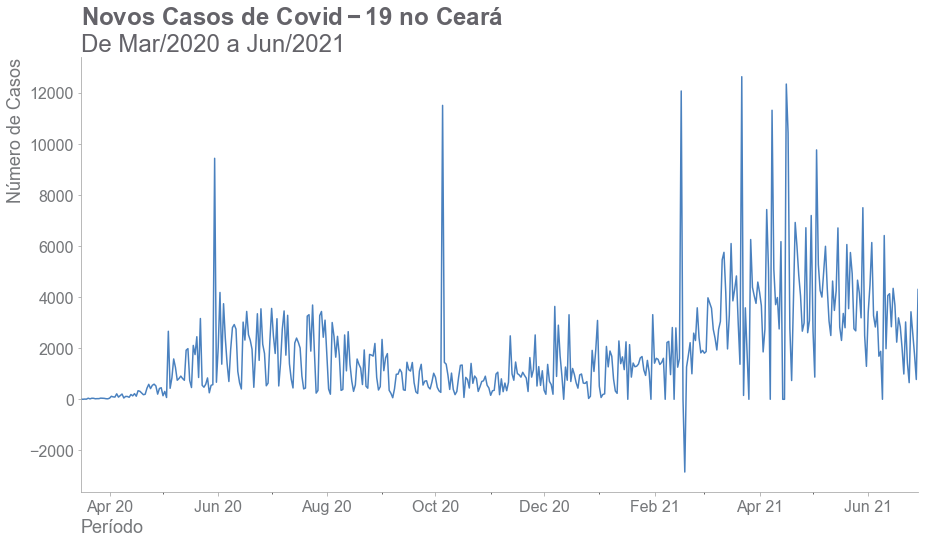

In [9]:
# plotagem dos novos casos de covid-19
ax = covid_ce.novos_casos.plot(color = BLUE2)
plt.title('$\\bf{Novos\ Casos\ de\ Covid-19\ no\ Ceará}$\nDe Mar/2020 a Jun/2021',
         fontsize = 24, loc = 'left', color = GRAY4)
ax.tick_params(color = 'darkgrey', bottom = 'off')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
sns.despine()

# intervalo dos ticks do eixo x
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 2))
# formata a data: %b - sigla do mês, %y - dois últimos dígitos do ano
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_color(GRAY5)

plt.ylabel('Número de Casos', loc = 'top', fontsize = 18, color = GRAY5)
plt.xlabel('Período', loc = 'left', fontsize = 18, color = GRAY5)

plt.show()

Essa série temporal está bastante poluída, até mesmo com valores abaixo de zero que podem representar correções nos dados. Uma melhor forma de visualizar isso seria com a média móvel.

In [10]:
# criando novas colunas no dataframe com a média móvel de novos casos e de novos óbitos
covid_ce['media_movel_casos'] = covid_ce['novos_casos'].rolling(window = 7, center = False).mean()
covid_ce['media_movel_obitos'] = covid_ce['novos_obitos'].rolling(window = 7, center = False).mean()

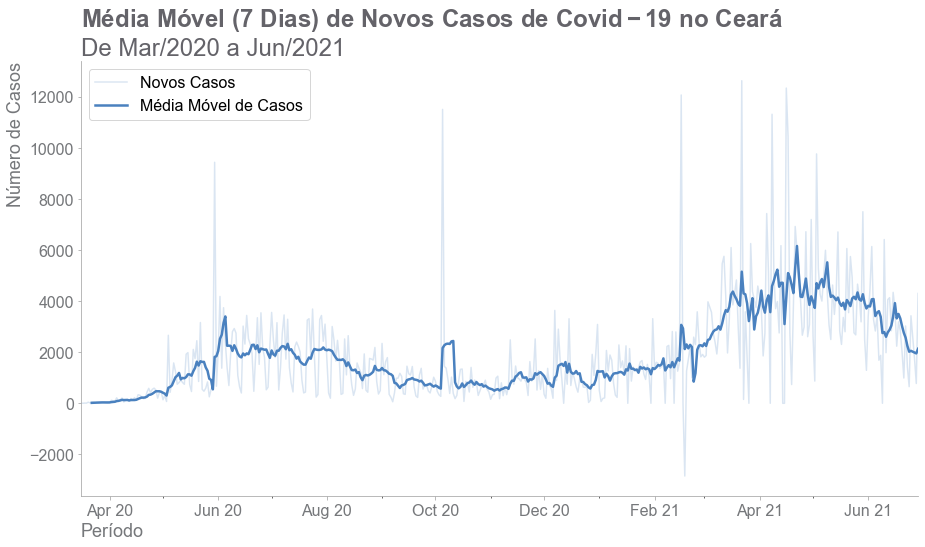

In [11]:
# plotagem da média móvel de novos casos de covid-19
ax = covid_ce['novos_casos'].plot(label = 'Novos Casos', alpha = 0.2, lw = 1.5, color = BLUE2)
covid_ce['media_movel_casos'].plot(label = 'Média Móvel de Casos', lw = 2.5, color = BLUE2)
plt.title('$\\bf{Média\ Móvel\ (7\ Dias)\ de\ Novos\ Casos\ de\ Covid-19\ no\ Ceará}$\nDe Mar/2020 a Jun/2021',
         fontsize = 24, loc = 'left', color = GRAY4)
ax.tick_params(color = 'darkgrey', bottom = 'off')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
sns.despine()

# intervalo dos ticks do eixo x
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 2))
# formata a data: %b - sigla do mês, %y - dois últimos dígitos do ano
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_color(GRAY5)

plt.ylabel('Número de Casos', loc = 'top', fontsize = 18, color = GRAY5)
plt.xlabel('Período', loc = 'left', fontsize = 18, color = GRAY5)

plt.legend()
plt.show()

Agora, ao utilizar a média móvel, temos uma série temporal bem mais comportada. Vamos olhar para o número de óbitos.

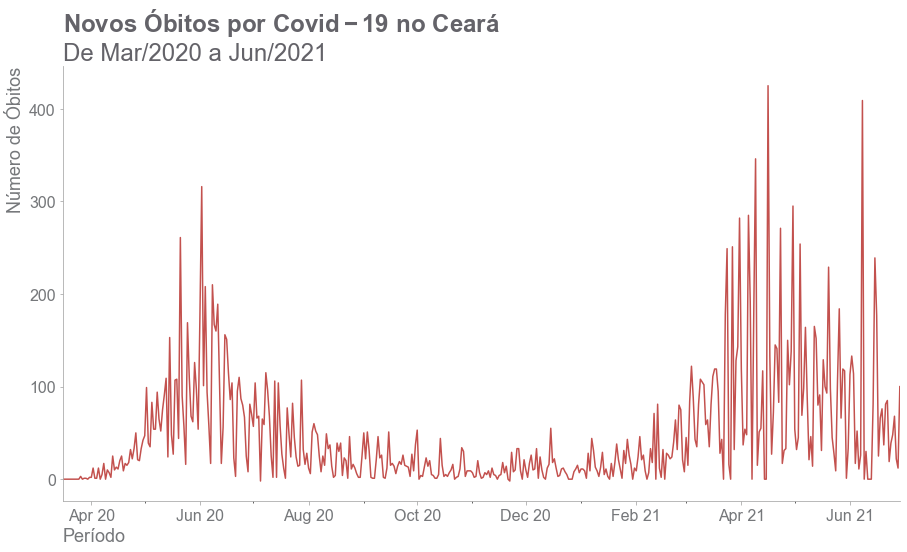

In [12]:
# plotagem dos novos óbitos por covid-19
ax = covid_ce.novos_obitos.plot(color = RED1)
plt.title('$\\bf{Novos\ Óbitos\ por\ Covid-19\ no\ Ceará}$\nDe Mar/2020 a Jun/2021',
         fontsize = 24, loc = 'left', color = GRAY4)
ax.tick_params(color = 'darkgrey', bottom = 'off')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
sns.despine()

# intervalo dos ticks do eixo x
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 2))
# formata a data: %b - sigla do mês, %y - dois últimos dígitos do ano
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_color(GRAY5)

plt.ylabel('Número de Óbitos', loc = 'top', fontsize = 18, color = GRAY5)
plt.xlabel('Período', loc = 'left', fontsize = 18, color = GRAY5)

plt.show()

Para o número de óbitos registrados diariamente não temos tantos valores abaixo de zero. Isso é de se esperar, pois o processo para registrar um óbito é bem mais complexo e burocrático, diminuindo a quantidade de erros inseridas no sistema.

Vamos agora olhar para a média móvel de novos óbitos.

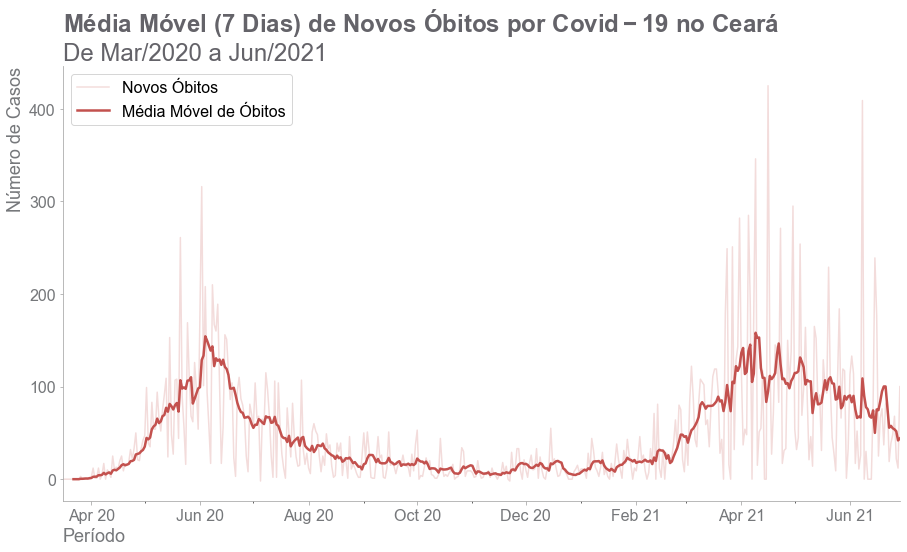

In [13]:
# plotagem da média móvel de novos óbitos por covid-19
ax = covid_ce['novos_obitos'].plot(label = 'Novos Óbitos', alpha = 0.2, lw = 1.5, color = RED1)
covid_ce['media_movel_obitos'].plot(label = 'Média Móvel de Óbitos', lw = 2.5, color = RED1)
plt.title('$\\bf{Média\ Móvel\ (7\ Dias)\ de\ Novos\ Óbitos\ por\ Covid-19\ no\ Ceará}$\nDe Mar/2020 a Jun/2021',
         fontsize = 24, loc = 'left', color = GRAY4)
ax.tick_params(color = 'darkgrey', bottom = 'off')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
sns.despine()

# intervalo dos ticks do eixo x
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 2))
# formata a data: %b - sigla do mês, %y - dois últimos dígitos do ano
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_color(GRAY5)

plt.ylabel('Número de Casos', loc = 'top', fontsize = 18, color = GRAY5)
plt.xlabel('Período', loc = 'left', fontsize = 18, color = GRAY5)

plt.legend()
plt.show()

Vamos comparar essas séries temporais.

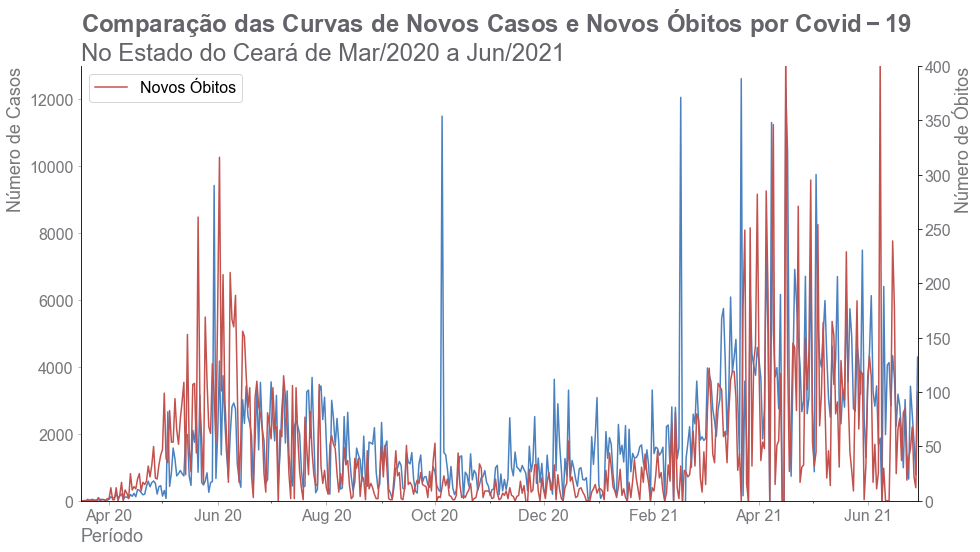

In [14]:
# plotagem das duas séries (novos casos e novos óbitos) para efeito de comparação dos picos
ax1 = covid_ce['novos_casos'].plot(label = 'Novos Casos', color = BLUE2)
ax2 = ax1.twinx()
ax2 = covid_ce['novos_obitos'].plot(label = 'Novos Óbitos', color = RED1)
plt.title('$\\bf{Comparação\ das\ Curvas\ de\ Novos\ Casos\ e\ Novos\ Óbitos\ por\ Covid-19}$\nNo Estado do Ceará de Mar/2020 a Jun/2021',
         fontsize = 24, loc = 'left', color = GRAY4)
ax1.tick_params(color = 'darkgrey', bottom = 'off')
ax1.spines['bottom'].set_color('darkgrey')
ax1.spines['left'].set_color('darkgrey')
ax1.spines['right'].set_color('darkgrey')
ax2.spines['top'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval = 2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

for i in ax1.get_yticklabels() + ax1.get_xticklabels():
    i.set_color(GRAY5)
for i in ax2.get_yticklabels() + ax2.get_xticklabels():
    i.set_color(GRAY5)

ax1.set_ylabel('Número de Casos', loc = 'top', fontsize = 18, color = GRAY5)
ax1.set_xlabel('Período', loc = 'left', fontsize = 18, color = GRAY5)
ax2.set_ylabel('Número de Óbitos', loc = 'top', fontsize = 18, color = GRAY5)

ax1.set_ylim(0, 13000)
ax2.set_ylim(0, 400)

plt.legend()
plt.show()

Mesmo sendo uma visualização poluída, conseguimos enxergar algumas conclusões.

Diferentemente de alguns outros estados, aqui, aparentemente, as duas curvas estão bem próximas, com pouco ou quase nenhum delay entre o número de morte e de novos casos no Ceará.

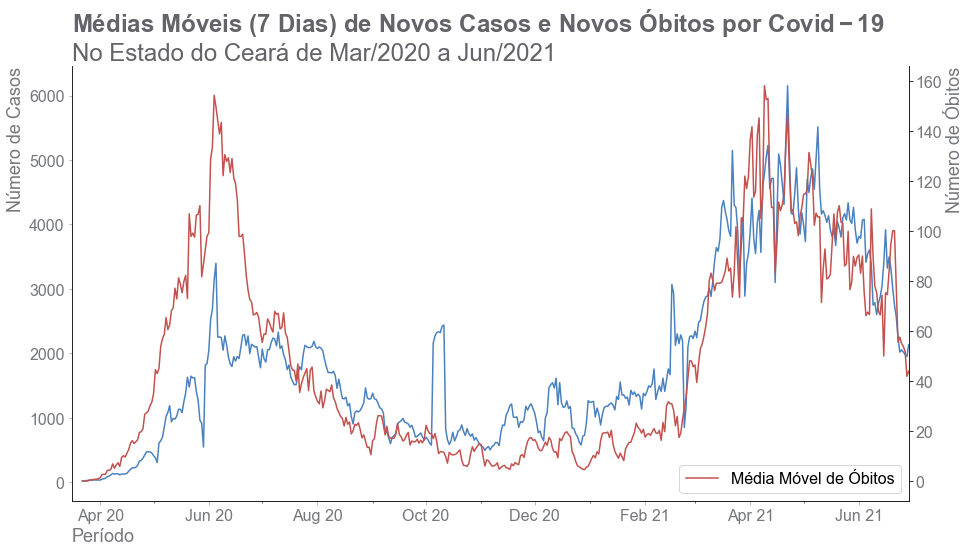

In [15]:
# plotagem das duas séries (média móvel de novos casos e de novos óbitos) para efeito de comparação dos picos
ax1 = covid_ce['media_movel_casos'].plot(label = 'Média Móvel de Casos', color = BLUE2)
ax2 = ax1.twinx()
ax2 = covid_ce['media_movel_obitos'].plot(label = 'Média Móvel de Óbitos', color = RED1)
plt.title('$\\bf{Médias\ Móveis\ (7\ Dias)\ de\ Novos\ Casos\ e\ Novos\ Óbitos\ por\ Covid-19}$\nNo Estado do Ceará de Mar/2020 a Jun/2021',
         fontsize = 24, loc = 'left', color = GRAY4)
ax1.tick_params(color = 'darkgrey', bottom = 'off')
ax1.spines['bottom'].set_color('darkgrey')
ax1.spines['left'].set_color('darkgrey')
ax1.spines['right'].set_color('darkgrey')
ax2.spines['top'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval = 2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

for i in ax1.get_yticklabels() + ax1.get_xticklabels():
    i.set_color(GRAY5)
for i in ax2.get_yticklabels() + ax2.get_xticklabels():
    i.set_color(GRAY5)

ax1.set_ylabel('Número de Casos', loc = 'top', fontsize = 18, color = GRAY5)
ax1.set_xlabel('Período', loc = 'left', fontsize = 18, color = GRAY5)
ax2.set_ylabel('Número de Óbitos', loc = 'top', fontsize = 18, color = GRAY5)

plt.legend()
plt.show()

As curvas acompanham bem uma a outra.

/home/carolina/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/carolina/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


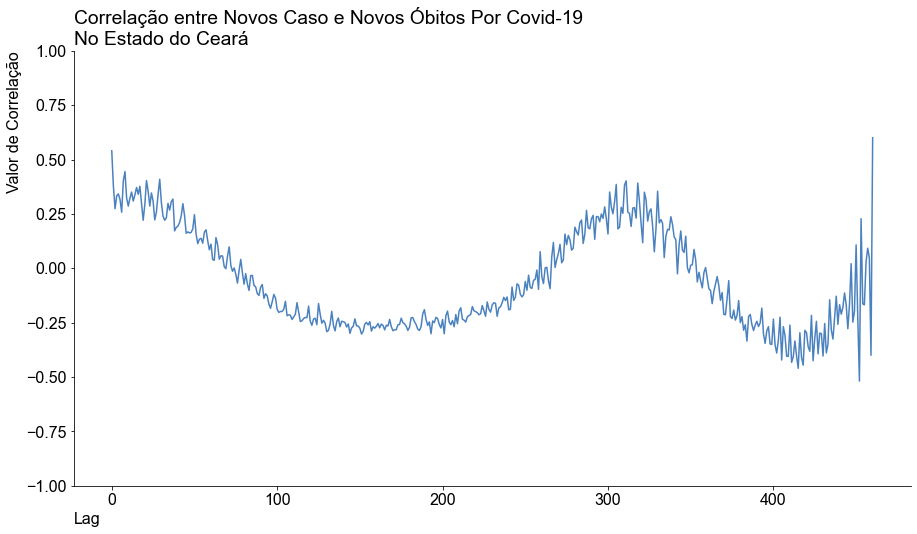

In [16]:
# correlação entre os novos casos e os novos óbitos
correlacao_obitos_casos = [covid_ce['novos_casos'].corr(covid_ce['novos_obitos'].shift(t)) for t in range(0, len(covid_ce))]
lag = range(0, len(covid_ce))
sns.lineplot(x = lag, y = correlacao_obitos_casos, color = BLUE2)
plt.ylim(-1, 1)
plt.title('Correlação entre Novos Caso e Novos Óbitos Por Covid-19\nNo Estado do Ceará', loc = 'left')
plt.xlabel('Lag', loc = 'left')
plt.ylabel('Valor de Correlação', loc = 'top')
sns.despine()
plt.show()

comentários sobre a correlação

# Previsões com o FBProphet

## Casos

In [17]:
# criação de um novo dataframe (de treino) no modelo aceito pelo Prophet
df_treino = pd.DataFrame()
df_treino['y'] = covid_ce['novos_casos'][:400]
df_treino['ds'] = covid_ce.index[:400]
df_treino.index = range(0, 400)
df_treino

,y,ds
0,9,2020-03-16
1,1,2020-03-17
2,9,2020-03-18
3,5,2020-03-19
4,44,2020-03-20
...,...,...
395,0,2021-04-15
396,12331,2021-04-16
397,10423,2021-04-17
398,2775,2021-04-18


In [18]:
# criação de um novo dataframe (de teste) no modelo aceito pelo Prophet
df_teste = pd.DataFrame()
df_teste['y'] = covid_ce['novos_casos'][400:]
df_teste['ds'] = covid_ce.index[400:]
df_teste.index = range(0, len(covid_ce) - 400)
df_teste

,y,ds
0,3911,2021-04-20
1,6917,2021-04-21
2,5979,2021-04-22
3,4852,2021-04-23
4,4044,2021-04-24
...,...,...
66,3424,2021-06-25
67,2610,2021-06-26
68,1753,2021-06-27
69,775,2021-06-28


In [19]:
modelo = Prophet(n_changepoints = 25,
                 changepoint_prior_scale = 10.0,
                 seasonality_mode = 'multiplicative',
                 holidays = feriados, weekly_seasonality = 7)
modelo.fit(df_treino)
dataframefuturo = modelo.make_future_dataframe(periods = 0)
previsao = modelo.predict(dataframefuturo)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


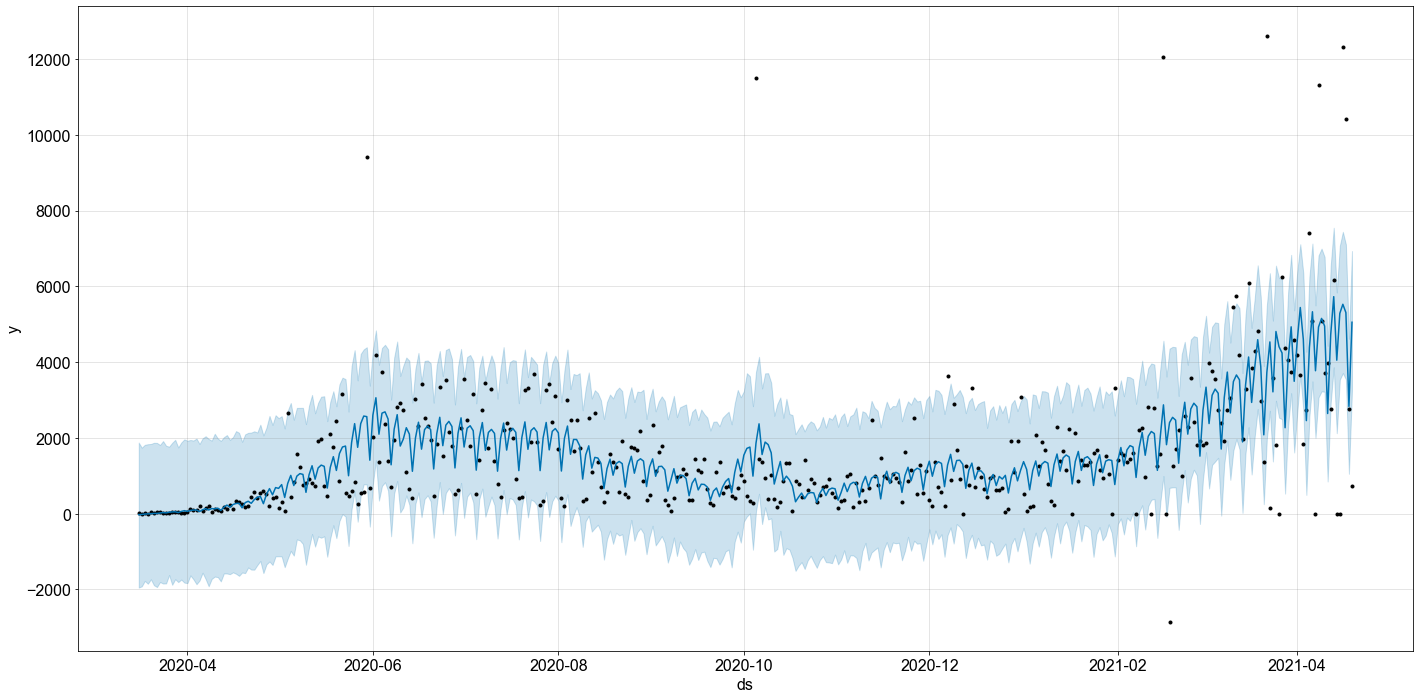

In [20]:
modelo.plot(previsao, figsize = (20,10));

In [21]:
novo_y = df_treino.reset_index()

In [22]:
sem_outliers = novo_y[(novo_y['y']> previsao['yhat_lower']) & (novo_y['y'] < previsao['yhat_upper'])]

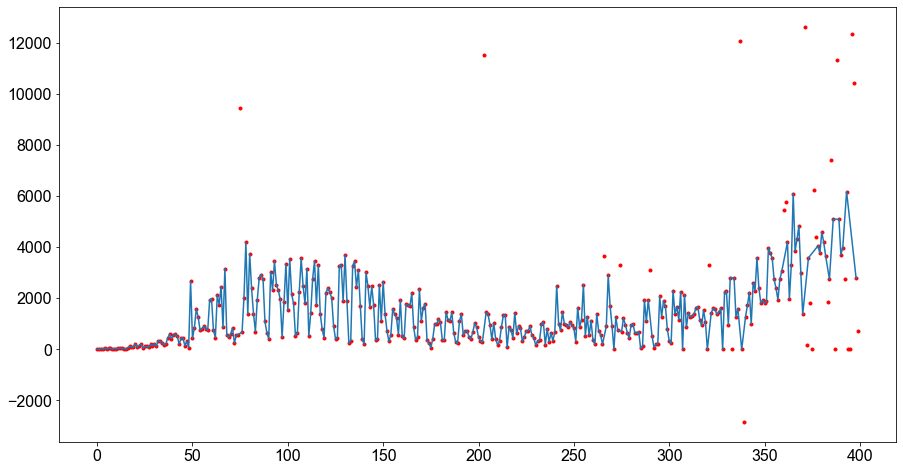

In [23]:
plt.plot(df_treino.index, df_treino['y'],'r.')
plt.plot(sem_outliers['index'], sem_outliers['y'])

In [24]:
df_sem_outliers = sem_outliers[['ds','y']]

In [25]:
modelo = Prophet(n_changepoints = 25,
                 changepoint_prior_scale = 10.0,
                 seasonality_mode = 'multiplicative',
                 holidays = feriados,
                 weekly_seasonality = 7)

modelo.fit(df_sem_outliers)
dataframefuturo = modelo.make_future_dataframe(periods = 71)
previsao = modelo.predict(dataframefuturo)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


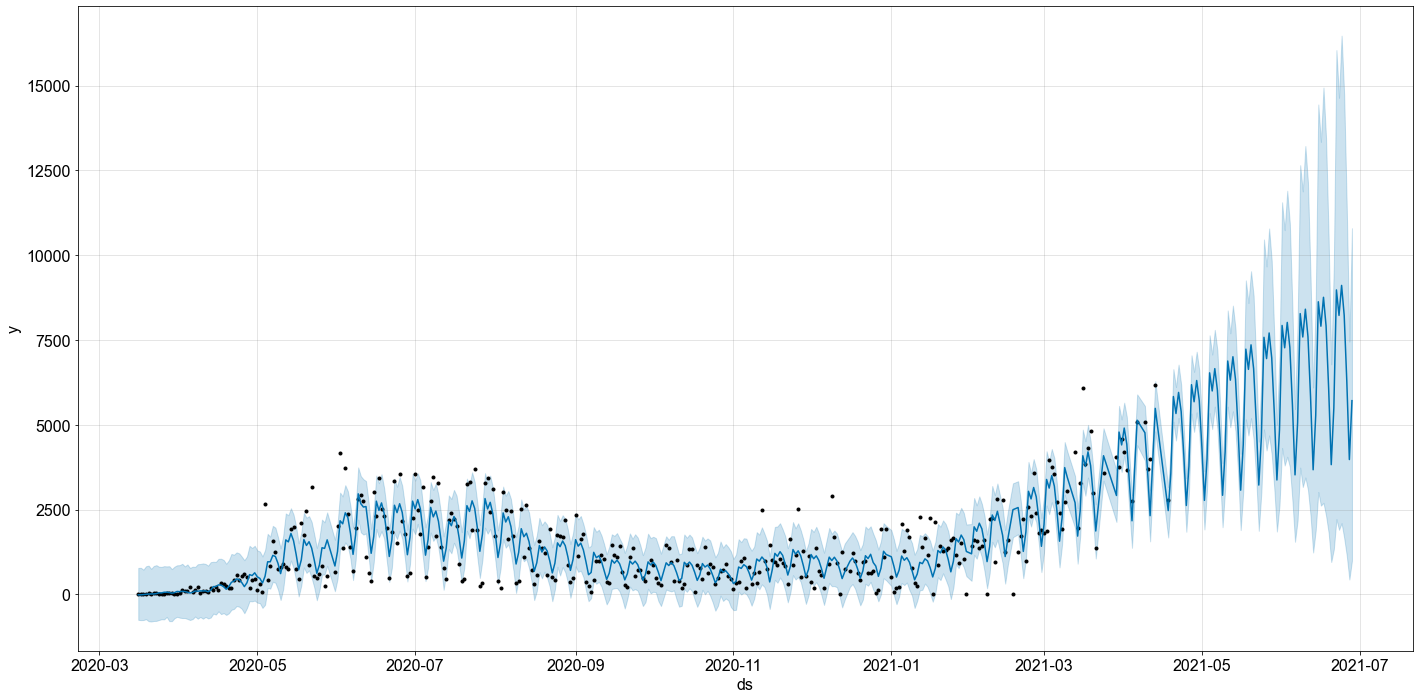

In [26]:
fig = modelo.plot(previsao, figsize = (20,10));

In [27]:
modelo = Prophet(n_changepoints = 25,
                 changepoint_range = 0.92,
                 changepoint_prior_scale = 0.1,
                 seasonality_mode = 'multiplicative',
                 holidays = feriados,
                 weekly_seasonality = 7)
modelo.fit(df_sem_outliers)
dataframefuturo = modelo.make_future_dataframe(periods = 71)
previsao = modelo.predict(dataframefuturo)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


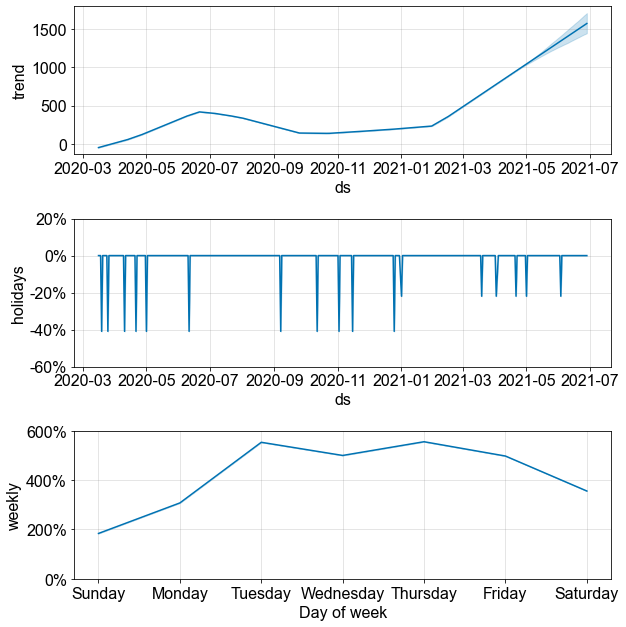

In [28]:
modelo.plot_components(previsao);

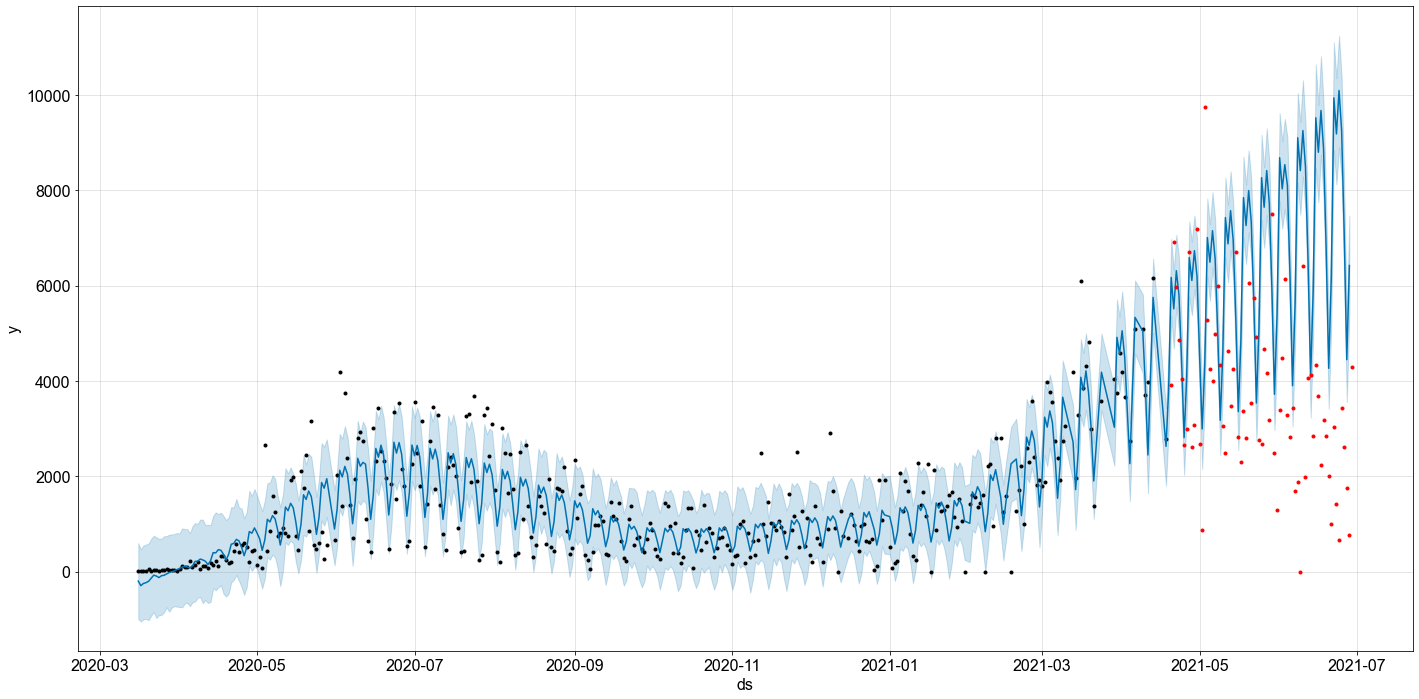

In [29]:
fig = modelo.plot(previsao, figsize = (20,10));
plt.plot(df_teste['ds'], df_teste['y'], '.r')

In [30]:
amostras = modelo.predictive_samples(previsao)

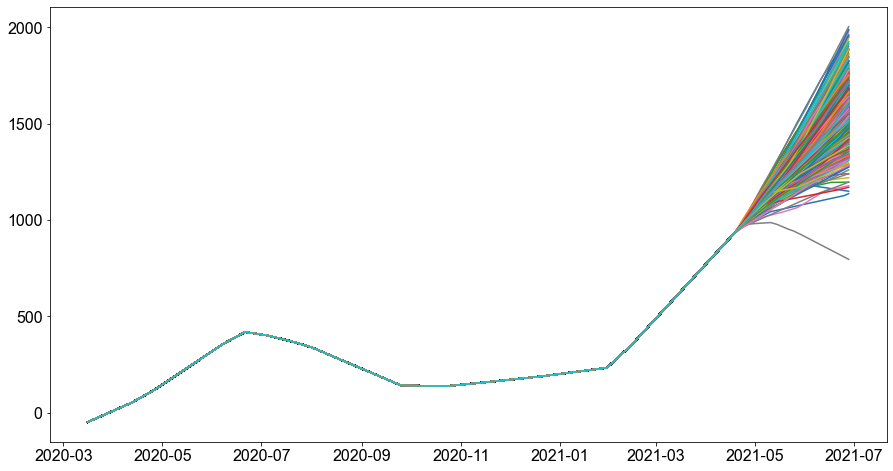

In [31]:
plt.plot(previsao['ds'], amostras['trend']);

## Óbitos

comentar do add regressor que deu errado

In [32]:
df_treino = pd.DataFrame()
df_treino['y'] = covid_ce['novos_obitos'][:400]
df_treino['ds'] = covid_ce.index[:400]
df_treino.index = range(0, 400)
df_treino

,y,ds
0,0,2020-03-16
1,0,2020-03-17
2,0,2020-03-18
3,0,2020-03-19
4,0,2020-03-20
...,...,...
395,0,2021-04-15
396,425,2021-04-16
397,133,2021-04-17
398,27,2021-04-18


In [33]:
df_teste = pd.DataFrame()
df_teste['y'] = covid_ce['novos_obitos'][400:]
df_teste['ds'] = covid_ce.index[400:]
df_teste.index = range(0, len(covid_ce) - 400)
df_teste

,y,ds
0,145,2021-04-20
1,141,2021-04-21
2,83,2021-04-22
3,271,2021-04-23
4,17,2021-04-24
...,...,...
66,48,2021-06-25
67,68,2021-06-26
68,22,2021-06-27
69,12,2021-06-28


In [34]:
modelo = Prophet(interval_width = 0.95,
                 n_changepoints = 25,
                 changepoint_prior_scale = 10.0,
                 seasonality_mode = 'multiplicative',
                 holidays = feriados,
                 weekly_seasonality = 7)
modelo.fit(df_treino)

dataframefuturo = modelo.make_future_dataframe(periods = 0)

previsao = modelo.predict(dataframefuturo)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


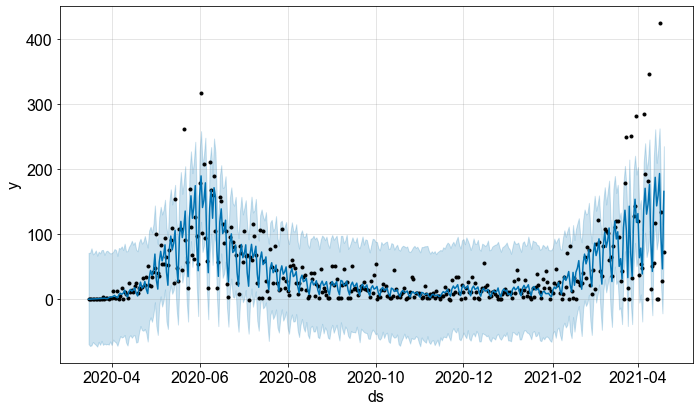

In [35]:
modelo.plot(previsao);

In [36]:
novo_y = df_treino.reset_index()

In [37]:
sem_outliers = novo_y[(novo_y['y'] > previsao['yhat_lower']) & (novo_y['y'] < previsao['yhat_upper'])]

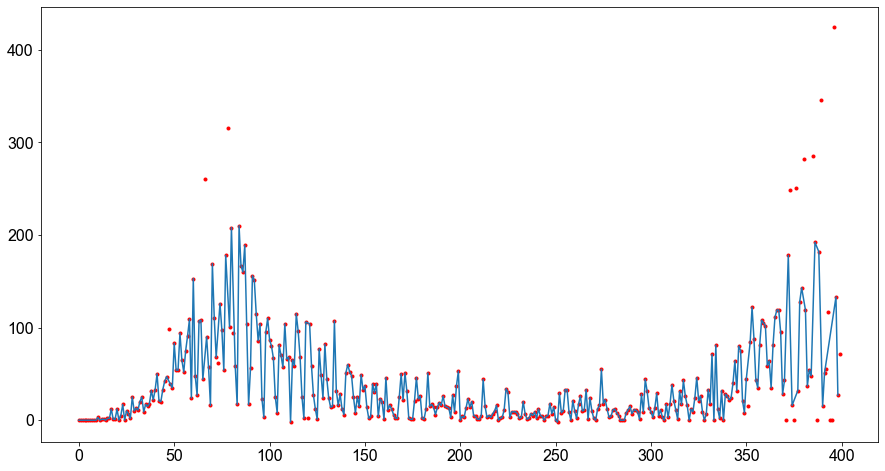

In [38]:
plt.plot(df_treino.index, df_treino['y'],'r.')
plt.plot(sem_outliers['index'], sem_outliers['y'])

In [39]:
df_sem_outliers = sem_outliers[['ds','y']]

In [40]:
modelo = Prophet(n_changepoints = 25,
                 changepoint_prior_scale = 10.0,
                 seasonality_mode = 'multiplicative',
                 holidays = feriados,
                 weekly_seasonality = 7)

modelo.fit(df_sem_outliers)
dataframefuturo = modelo.make_future_dataframe(periods = 71)
previsao = modelo.predict(dataframefuturo)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


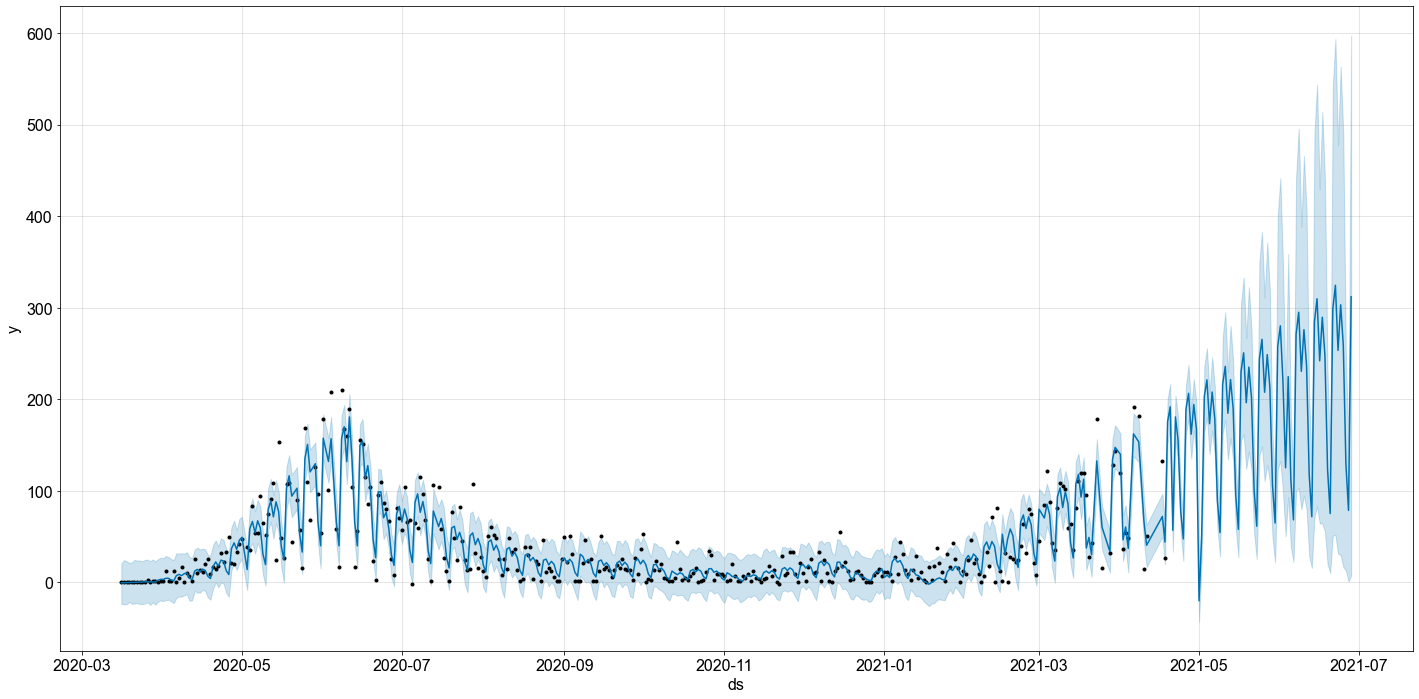

In [41]:
fig = modelo.plot(previsao, figsize = (20,10));

In [42]:
modelo = Prophet(n_changepoints = 25,
                 changepoint_range = 0.92,
                 changepoint_prior_scale = 0.1,
                 seasonality_mode = 'multiplicative',
                 holidays = feriados,
                 weekly_seasonality = 7)
modelo.fit(df_sem_outliers)
dataframefuturo = modelo.make_future_dataframe(periods = 71)
previsao = modelo.predict(dataframefuturo)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


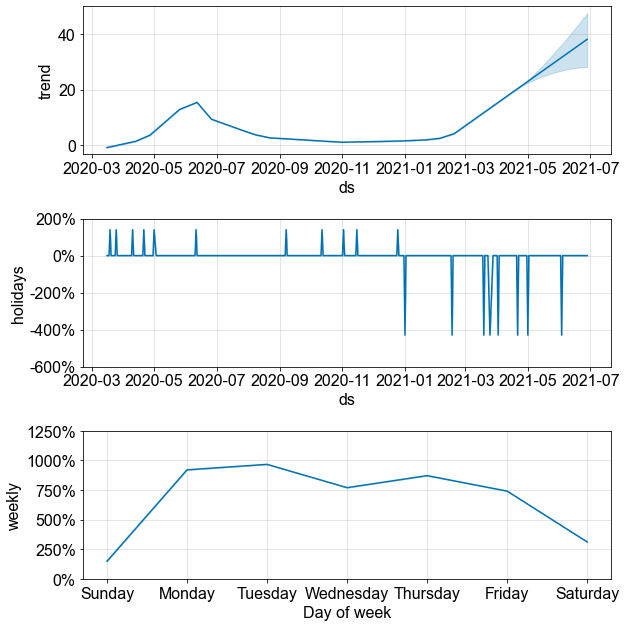

In [43]:
modelo.plot_components(previsao);

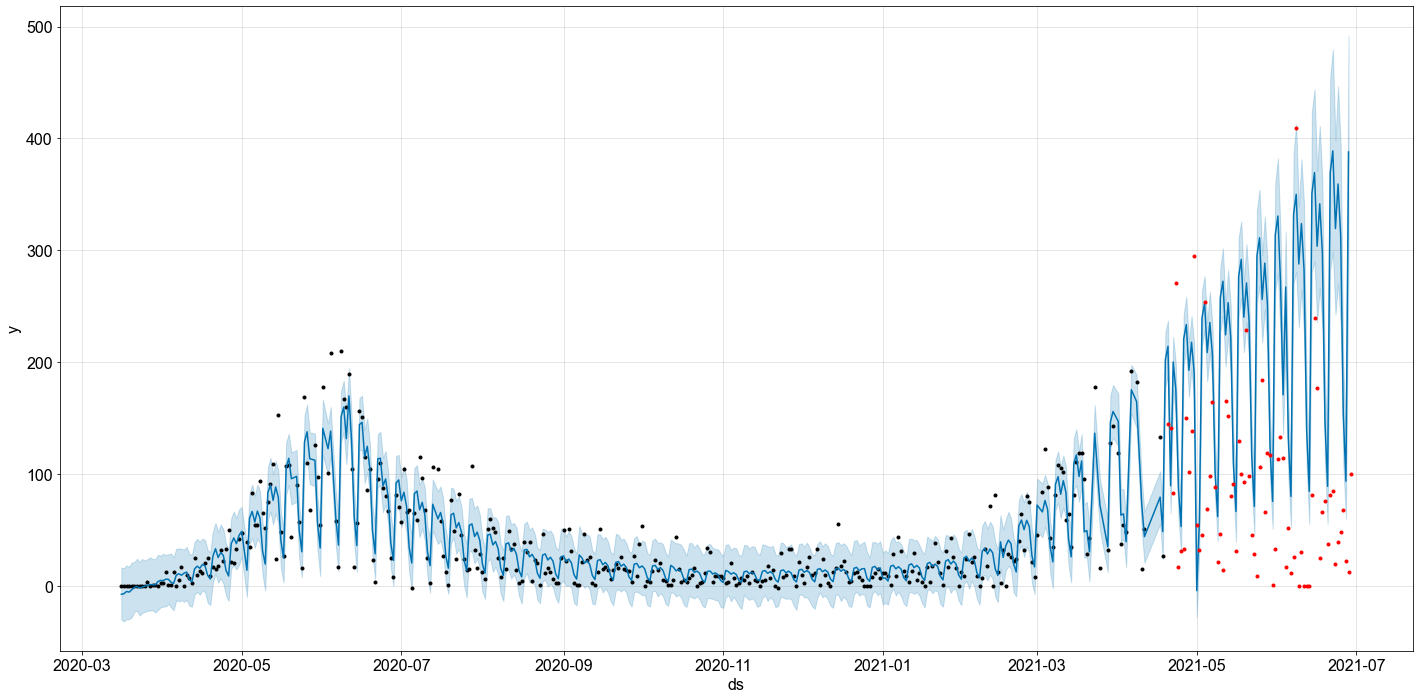

In [44]:
fig = modelo.plot(previsao, figsize = (20,10));
plt.plot(df_teste['ds'], df_teste['y'], '.r')

In [45]:
amostras = modelo.predictive_samples(previsao)

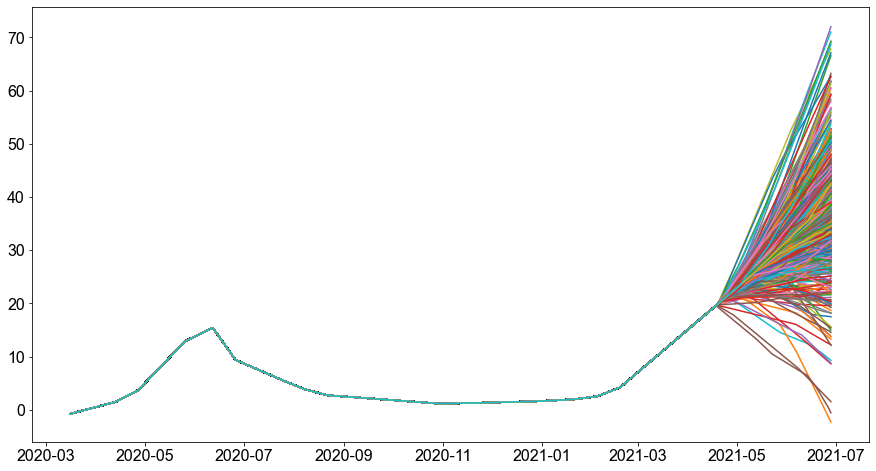

In [46]:
plt.plot(previsao['ds'], amostras['trend']);

# Breve Análise da Vacinação Contra a Covid-19

Será que com os dados que já temos disponíveis sobre a vacinação contra a Covid-19 no Ceará já é possível dizer que o número de casos da doença ou o número de mortes está diminuindo? Acredito que seja cedo ainda para dizer, mas talvez já exista esperança em uma queda nos casos e nos óbitos, podende ser ou não causada pelas vacinas.

Vamos perguntar aos dados!

In [47]:
vacinas_ce = pd.read_csv('../data/vacina_total_ce.csv')

In [48]:
vacinas_ce.head()

,vacina_dataaplicacao,quantidade
0,2018-02-11,1
1,2020-03-23,43896
2,2021-01-01,29
3,2021-01-04,22
4,2021-01-12,7


In [49]:
vacinas_ce['vacina_dataaplicacao'] = pd.to_datetime(vacinas_ce['vacina_dataaplicacao'], format = '%Y-%m-%d')

In [50]:
vacinas_ce = vacinas_ce.set_index('vacina_dataaplicacao').rename_axis(None)

In [51]:
vacinas_ce = vacinas_ce[2:]

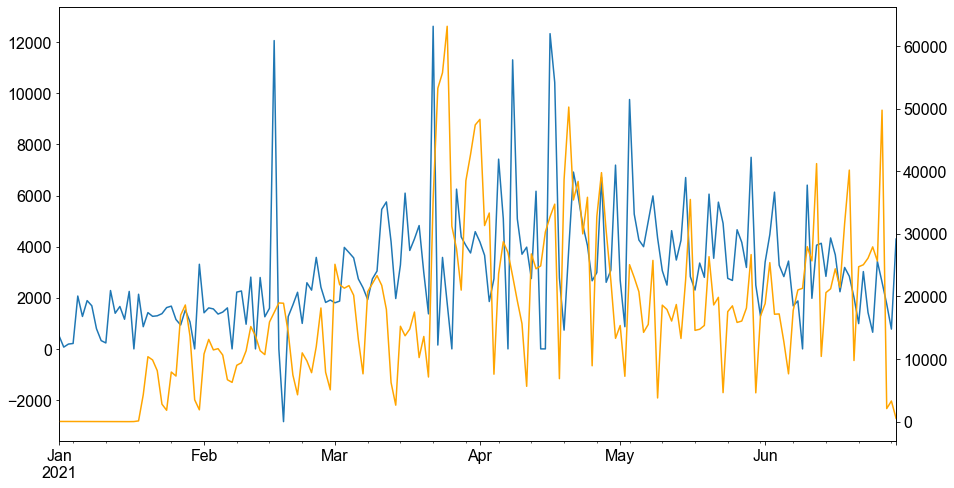

In [52]:
ax1 = covid_ce['novos_casos'].plot()
ax2 = ax1.twinx()
ax2 = vacinas_ce['quantidade'].plot(color = 'orange')

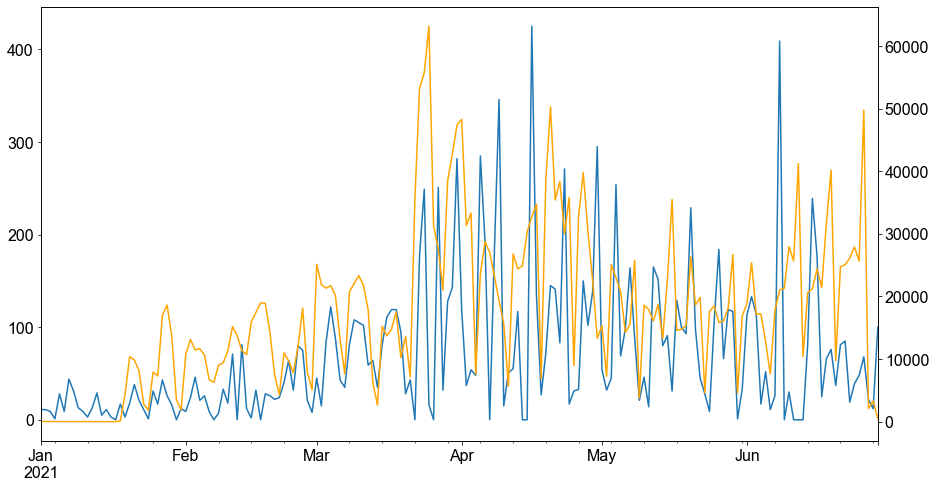

In [53]:
ax1 = covid_ce['novos_obitos'].plot()
ax2 = ax1.twinx()
ax2 = vacinas_ce['quantidade'].plot(color = 'orange')

Casos não aparentam ter uma grande queda, óbitos talvez, levemente. Olhar para a média móvel, que é basicamente a trend.

In [54]:
# criando novas colunas no dataframe
vacinas_ce['mm_aplicacao_vacs'] = vacinas_ce['quantidade'].rolling(window = 7, center = False).mean()

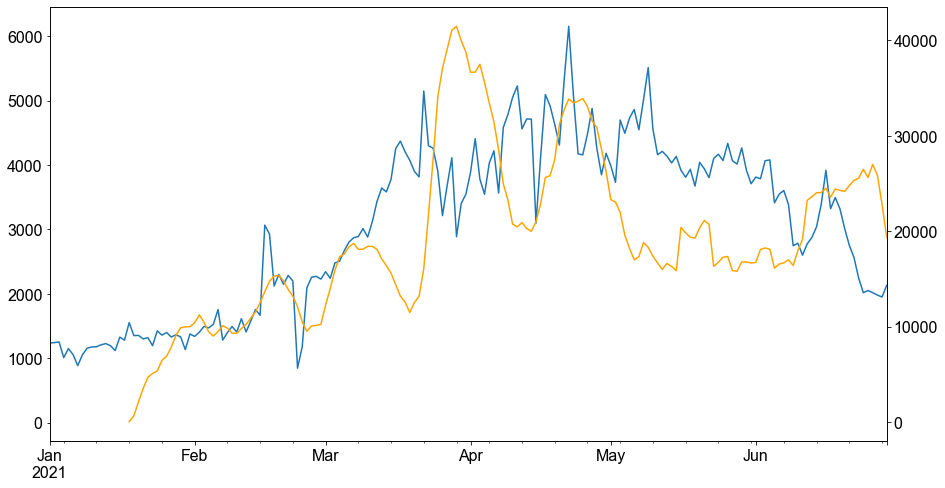

In [55]:
ax1 = covid_ce['media_movel_casos'].plot()
ax2 = ax1.twinx()
ax2 = vacinas_ce['mm_aplicacao_vacs'].plot(color = 'orange')

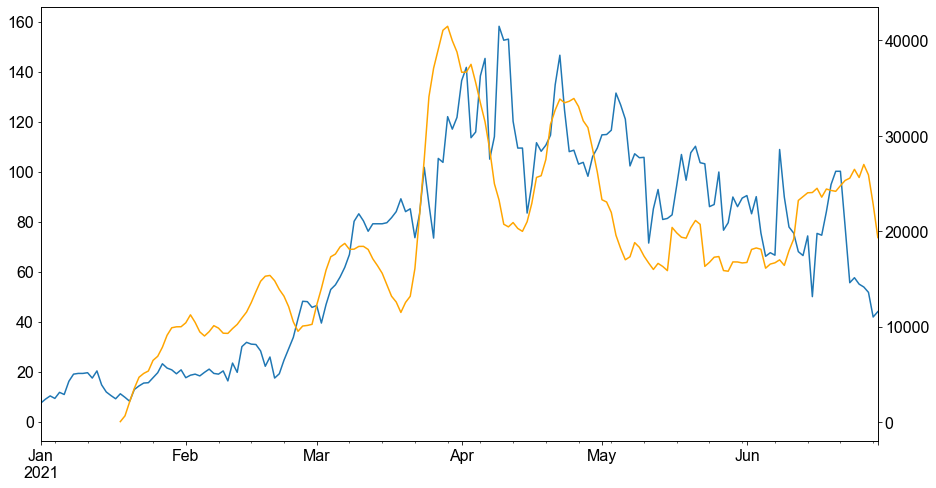

In [56]:
ax1 = covid_ce['media_movel_obitos'].plot()
ax2 = ax1.twinx()
ax2 = vacinas_ce['mm_aplicacao_vacs'].plot(color = 'orange')

Por último, quero comparar a quantidade de vacinas aplicadas em homens e mulheres, para identificar qual gênero mais se vacinou. Essa análise foi motivada por esse artigo interessantíssimo: [Why Is There Such A Gender Gap In COVID-19 Vaccination Rates?](https://fivethirtyeight.com/features/why-is-there-such-a-gender-gap-in-covid-19-vaccination-rates/)

In [57]:
vac_por_sb = pd.read_csv('../data/vacina_sexo_biologico.csv')
vac_por_sb

,paciente_enumsexobiologico,quantidade
0,F,1875667
1,I,6
2,M,1330884


[]

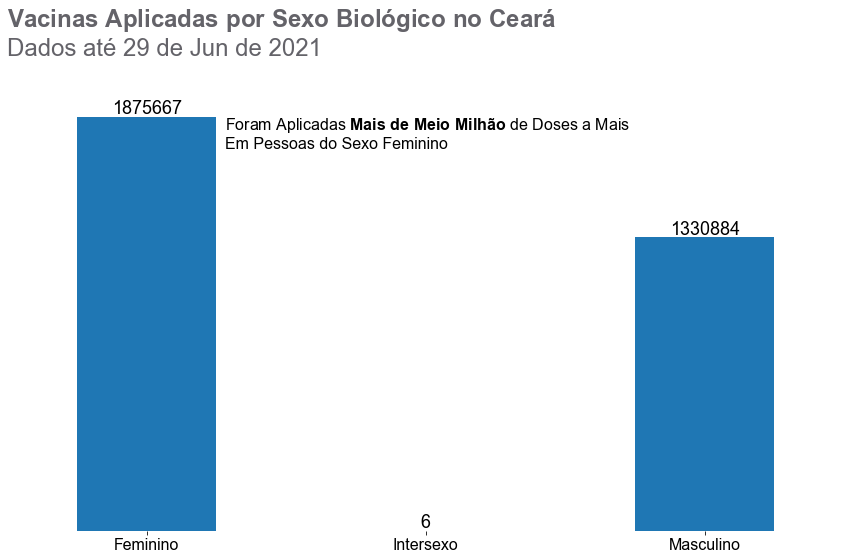

In [58]:
ax = vac_por_sb.quantidade.plot(kind = 'bar')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xticklabels(['Feminino', 'Intersexo', 'Masculino'], rotation = 0)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha = 'center', va = 'center',
                    size = 18, xytext = (0, 8),
                    textcoords = 'offset points')
    
ax.axes.get_yaxis().set_visible(False)

plt.title('$\\bf{Vacinas\ Aplicadas\ por\ Sexo\ Biológico\ no\ Ceará}$\nDados até 29 de Jun de 2021',
        fontsize = 24, loc = 'left', color = GRAY4, y = 1.08)

plt.text(0.28, 1730000, 'Foram Aplicadas $\\bf{Mais\ de\ Meio\ Milhão}$ de Doses a Mais\nEm Pessoas do Sexo Feminino')

sns.despine(left = True, bottom = True)
plt.plot()

Isso vai de encontro ao artigo. Cito aqui as principais hipóteses:
-
-
-
-


# Conclusão

# Proposta de Melhorias

# Referências